À l'origine j'avais fait un réseau de neurones sur des images en nuances de gris mais pour améliorer les performances j'ai décidé de passer à des images couleur le raisonnement et le même sauf qu'au lieu d'avoir un canal à trainer nous en avons 3 pour les couches de convolution et au moment de charger les images nous les convertissons en RGB au lieu de GRAYSCALE.

# Load the librairies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
import cv2
import os
import sys
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Dropout,Input,Flatten,BatchNormalization,Activation,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.callbacks import TensorBoard,ModelCheckpoint
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
# Set the seed to get the same result.
np.random.seed(50)
tf.random.set_seed(50)

# Load the dataset
The dataset are available at this link : https://www.kaggle.com/mariafrenti/age-prediction

In [3]:
# Set the path of train dataset and test dataset 
train_path = "age_prediction_up/age_prediction/train/"
test_path = "age_prediction_up/age_prediction/test/"
shape_of_images = (150,150) 

In [4]:
# Load all image in list
def load_dataset(path,shape_of_images = (150,150)):
    list_labels = os.listdir(path)
    images = []
    labels = []
    for label in list_labels:
        if(os.path.isdir(path+label)):
            files_in_label = os.listdir(path+label+"/")
            for file in files_in_label:
                ext_of_file = file.split(".")[-1].lower()
                if (ext_of_file=="png" or ext_of_file=="jpg" or ext_of_file=="jpeg"):
                    image = cv2.imread(path+label+"/"+file)
                    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image,shape_of_images)
                    images.append(image)
                    labels.append(float(label))
    return images,labels

In [5]:
# Load train dataset
X_train,y_train = load_dataset(train_path,shape_of_images)
print(len(X_train),len(y_train))

185632 185632


In [6]:
# Convert list into ndarray
X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train.shape,y_train.shape)

(185632, 150, 150, 3) (185632,)


In [7]:
X_train.dtype

dtype('uint8')

In [8]:
 sys.getsizeof(X_train)

12530160152

In [10]:
X_test,y_test = load_dataset(test_path,shape_of_images)
print(len(X_test),len(y_test))

47568 47568


In [11]:
X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape,y_test.shape,X_test.dtype)

(47568, 150, 150, 3) (47568,) uint8


(150, 150, 3)


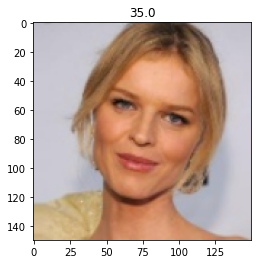

In [13]:
# plot an image
print(X_train[0].shape)
plt.imshow(X_train[90000])
plt.title(y_train[90000])
plt.show()

In [14]:
# Save the ndarray into files to win time
np.save("X_train_c.npy",X_train)
np.save("X_test_c.npy",X_test)
np.save("y_train_c.npy",y_train)
np.save("y_test_c.npy",y_test)

In [4]:
# Load the data directly from file
X_train = np.load("X_train_c.npy")
X_test = np.load("X_test_c.npy")
y_train = np.load("y_train_c.npy")
y_test = np.load("y_test_c.npy")

In [5]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(185632, 150, 150, 3) (185632,) (47568, 150, 150, 3) (47568,)


In [6]:
from sklearn.model_selection import train_test_split

In [7]:
# Split the train dataset with 75% for training and 25% for validation
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.25,random_state=50)

In [8]:
# Set the parameters for tensorflow
batch_size = 128
n_train = X_train.shape[0]
n_val = X_val.shape[0]
epochs = 50

In [12]:
# Set the generator parameters for data augmentation
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,)
val_datagen = ImageDataGenerator()

In [10]:
print(X_train.shape,y_train.shape,X_val.shape,y_val.shape)

(139224, 150, 150, 3) (139224,) (46408, 150, 150, 3) (46408,)


In [13]:
train_generator = train_datagen.flow(X_train, y_train,batch_size=batch_size)
val_generator = val_datagen.flow(X_val,y_val, batch_size=batch_size)

In [14]:
import gc

In [15]:
# To win 12GB of memory 
del X_train
del y_train

In [16]:
# To free memory if necessary
gc.collect()

0

# Define the model

In [17]:
# Set the convnet with 5 block of convolution and 2 dense layers after
model = Sequential()
model.add(Input((150,150,3)))
model.add(Conv2D(64,3,padding="same",kernel_initializer='lecun_normal',activation="selu"))
model.add(Conv2D(64,3,padding="same",kernel_initializer='lecun_normal',activation="selu"))
model.add(MaxPooling2D(2))
model.add(SpatialDropout2D(0.4))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(128,3,padding="same",kernel_initializer='lecun_normal',activation="selu"))
model.add(Conv2D(128,3,padding="same",kernel_initializer='lecun_normal',activation="selu"))
model.add(MaxPooling2D(2))
model.add(SpatialDropout2D(0.4))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(256,3,padding="same",kernel_initializer='lecun_normal',activation="selu"))
model.add(Conv2D(256,3,padding="same",kernel_initializer='lecun_normal',activation="selu"))
model.add(Conv2D(256,3,padding="same",kernel_initializer='lecun_normal',activation="selu"))
model.add(MaxPooling2D(2))
model.add(SpatialDropout2D(0.4))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(512,3,padding="same",kernel_initializer='lecun_normal',activation="selu"))
model.add(Conv2D(512,3,padding="same",kernel_initializer='lecun_normal',activation="selu"))
model.add(Conv2D(512,3,padding="same",kernel_initializer='lecun_normal',activation="selu"))
model.add(MaxPooling2D(2))
model.add(SpatialDropout2D(0.4))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(1024,3,padding="same",kernel_initializer='lecun_normal',activation="selu"))
model.add(Conv2D(1024,3,padding="same",kernel_initializer='lecun_normal',activation="selu"))
model.add(MaxPooling2D(2))
model.add(SpatialDropout2D(0.4))
model.add(BatchNormalization(axis=3))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(1,activation="linear"))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 64)       0         
 )                                                               
                                                                 
 spatial_dropout2d (SpatialD  (None, 75, 75, 64)       0         
 ropout2D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 75, 75, 64)       256       
 ormalization)                                                   
                                                        

In [20]:
model.compile(optimizer=Adam(),
              loss="mse",)
# We will consider the problem of age like regression and not classification

# Train the model

In [21]:
# Old name is CNN_Age_150x150_Selu
NAME = "CNN_Age_150x150x3_Selu"
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
checkpoint = ModelCheckpoint(filepath='ModelSave/CNN_Age_150x150x3.{epoch:02d}.h5',save_best_only=True)

In [22]:
history = model.fit(train_generator,
                    epochs=epochs,
                    steps_per_epoch = n_train//batch_size,
                    validation_data = val_generator,
                    validation_steps = n_val//batch_size,
                    callbacks = [tensorboard,checkpoint])

Epoch 1/50
1087/1087 [==============================] - 704s 636ms/step - loss: 262.5842 - val_loss: 207.1406
Epoch 2/50
1087/1087 [==============================] - 620s 570ms/step - loss: 240.9974 - val_loss: 205.5698
Epoch 3/50
1087/1087 [==============================] - 616s 566ms/step - loss: 235.0316 - val_loss: 199.6891
Epoch 4/50
1087/1087 [==============================] - 614s 565ms/step - loss: 232.1861 - val_loss: 205.8137
Epoch 5/50
1087/1087 [==============================] - 598s 550ms/step - loss: 231.1777 - val_loss: 226.3044
Epoch 6/50
1087/1087 [==============================] - 603s 555ms/step - loss: 228.8899 - val_loss: 194.7925
Epoch 7/50
1087/1087 [==============================] - 599s 550ms/step - loss: 226.6583 - val_loss: 198.1919
Epoch 8/50
1087/1087 [==============================] - 601s 552ms/step - loss: 224.3034 - val_loss: 194.2965
Epoch 9/50
1087/1087 [==============================] - 595s 548ms/step - loss: 220.2998 - val_loss: 185.3712
Epoch 10/5

In [23]:
model.save("ModelSave/CNN_M2_Age_150x150x3_50.h5")

In [17]:
model = tf.keras.models.load_model("ModelSave/CNN_M2_Age_150x150x3_50.h5")

The code after is not run again because it's long to train a neural network but it will be run soon

In [18]:
# It seem like the model not give good result and need more train
# So we didn't begin a new fit with more epoch. We take the last train model and continue to fit him
NAME = "CNN_Age_150x150_3_Suite_"
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
checkpoint = ModelCheckpoint(filepath='ModelSave/CNN_M2_Age_150x150x3_Suite.{epoch:02d}.h5',save_best_only=True)

In [ ]:
history = model.fit(train_generator,
                    epochs=epochs,
                    steps_per_epoch = n_train//batch_size,
                    validation_data = val_generator,
                    validation_steps = n_val//batch_size,
                    callbacks = [tensorboard,checkpoint])

In [22]:
model.save("ModelSave/CNN_M2_Age_150x150x3_Final100.h5")

In [21]:
model = tf.keras.models.load_model("ModelSave/CNN_M2_Age_150x150_Final130.h5")

If we find that the model, it's not enough good we can try to use the trained conv layers with a new model after which have more layers and units

I didn't do that directly with the model because I didn't have enough memory on my GPU.

In [17]:
new_model = Sequential()

In [18]:
for conv_layers in model.layers[:-5]:
    new_model.add(conv_layers)

In [19]:
new_model.build(input_shape = (None,150,150,3))

In [20]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 150, 150, 64)      640       
                                                                 
 conv2d_25 (Conv2D)          (None, 150, 150, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_10 (Bat  (None, 75, 75, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_26 (Conv2D)          (None, 75, 75, 128)       7

In [21]:
for conv_layers in new_model.layers[:-6]:
    conv_layers.trainable = False

In [22]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 150, 150, 64)      640       
                                                                 
 conv2d_25 (Conv2D)          (None, 150, 150, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_10 (Bat  (None, 75, 75, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_26 (Conv2D)          (None, 75, 75, 128)       7

In [23]:
new_model.add(Dense(2048,kernel_initializer='lecun_normal',activation="selu"))
new_model.add(Dropout(0.4))
new_model.add(Dense(1024,kernel_initializer='lecun_normal',activation="selu"))
new_model.add(Dropout(0.4))
new_model.add(Dense(512,kernel_initializer='lecun_normal',activation="selu"))
new_model.add(Dropout(0.4))
new_model.add(Dense(256,kernel_initializer='lecun_normal',activation="selu"))
new_model.add(Dropout(0.4))
new_model.add(Dense(1,activation="linear"))

In [24]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 150, 150, 64)      640       
                                                                 
 conv2d_25 (Conv2D)          (None, 150, 150, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_10 (Bat  (None, 75, 75, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_26 (Conv2D)          (None, 75, 75, 128)       7

In [19]:
new_model = tf.keras.models.load_model("FineTuningModel_Notrain.h5")

In [20]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 150, 150, 64)      640       
                                                                 
 conv2d_45 (Conv2D)          (None, 150, 150, 64)      36928     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                            
                                                                 
 dropout_26 (Dropout)        (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_19 (Bat  (None, 75, 75, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_46 (Conv2D)          (None, 75, 75, 128)      

In [25]:
new_model.compile(optimizer=Adam(),
              loss="mse")

In [26]:
NAME = "CNN_Age_150x150_Fine_Tunning"
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
checkpoint = ModelCheckpoint(filepath='ModelSave/CNN_Age_150x150_FineTun.{epoch:02d}.h5',
                             save_best_only=True)

In [27]:
history = new_model.fit(train_generator,
                    epochs=epochs,
                    steps_per_epoch = n_train//batch_size,
                    validation_data = val_generator,
                    validation_steps = n_val//batch_size,
                    callbacks = [tensorboard,checkpoint]) 

Epoch 1/50
1087/1087 [==============================] - 227s 197ms/step - loss: 102.6732 - val_loss: 81.1294
Epoch 2/50
1087/1087 [==============================] - 209s 192ms/step - loss: 89.4107 - val_loss: 90.3977
Epoch 3/50
1087/1087 [==============================] - 211s 194ms/step - loss: 82.2076 - val_loss: 72.0596
Epoch 4/50
1087/1087 [==============================] - 240s 221ms/step - loss: 78.0738 - val_loss: 69.8221
Epoch 5/50
1087/1087 [==============================] - 207s 190ms/step - loss: 77.5475 - val_loss: 70.5376
Epoch 6/50
1087/1087 [==============================] - 211s 194ms/step - loss: 76.5245 - val_loss: 69.8007
Epoch 7/50
1087/1087 [==============================] - 206s 190ms/step - loss: 75.9173 - val_loss: 70.2144
Epoch 8/50
1087/1087 [==============================] - 207s 190ms/step - loss: 75.3445 - val_loss: 75.5672
Epoch 9/50
1087/1087 [==============================] - 206s 190ms/step - loss: 74.8132 - val_loss: 70.8972
Epoch 10/50
1087/1087 [====

KeyboardInterrupt: 

In [15]:
new_model = tf.keras.models.load_model("FineTun_Notrain_Selu2.h5")

In [16]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 150, 150, 64)      640       
                                                                 
 conv2d_25 (Conv2D)          (None, 150, 150, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_10 (Bat  (None, 75, 75, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_26 (Conv2D)          (None, 75, 75, 128)      

In [19]:
new_model.compile(optimizer=Adam(),
                  loss="mse")

In [20]:
NAME = "CNN_Age_150x150_Fine_TunningSelu2"
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
checkpoint = ModelCheckpoint(filepath='ModelSave/CNN_Age_150x150_FineTun_Selu2.{epoch:02d}.h5',
                             save_best_only=True)

In [ ]:
history = new_model.fit(train_generator,
                    epochs=epochs,
                    steps_per_epoch = n_train//batch_size,
                    validation_data = val_generator,
                    validation_steps = n_val//batch_size,
                    callbacks = [tensorboard,checkpoint]) 

Epoch 1/50
1087/1087 [==============================] - 276s 234ms/step - loss: 93.0055 - val_loss: 79.3733
Epoch 2/50
1087/1087 [==============================] - 237s 218ms/step - loss: 92.8162 - val_loss: 73.6345
Epoch 3/50
1087/1087 [==============================] - 231s 213ms/step - loss: 86.2018 - val_loss: 77.0256
Epoch 4/50
1087/1087 [==============================] - 236s 217ms/step - loss: 84.9298 - val_loss: 73.0065
Epoch 5/50
1087/1087 [==============================] - 232s 213ms/step - loss: 84.0758 - val_loss: 75.4902
Epoch 6/50
1087/1087 [==============================] - 231s 213ms/step - loss: 84.0790 - val_loss: 74.0803
Epoch 7/50
1087/1087 [==============================] - 231s 213ms/step - loss: 83.9122 - val_loss: 73.3821
Epoch 8/50
1087/1087 [==============================] - 227s 208ms/step - loss: 83.7631 - val_loss: 73.5776
Epoch 9/50
1087/1087 [==============================] - 231s 213ms/step - loss: 84.2206 - val_loss: 75.7925
Epoch 10/50
1087/1087 [=====